In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm


def set_fatty_liver_categories(stiffness):
    """
    Given liver stiffness value, assigns a string labeled Normal, Moderate, Severe, or Cirrhosis.
    :param stiffness: float of Liver stiffness in kPa.
    :return: string of bucket to value is to be categorized in.
    """
    if stiffness < 7.5:
        return "Normal"
    elif 7.5 <= stiffness < 10:
        return "Moderate"
    elif 10 <= stiffness < 14:
        return "Severe"
    elif stiffness >= 14:
        return "Cirrhosis"

def adjust_edu_values(edu):
    """
    Assigns education level codes a descriptive label.
    :param edu: int education level code.
    :return: string descriptive label for education level code.
    """
    if edu == 1:
        return "Less than 9th grade"
    elif edu == 2:
        return "9-11th grade (includes 12th but no diploma)"
    elif edu == 3:
        return "High school graduate / GED or equivalent"
    elif edu == 4:
        return "Some college or AA degree"
    elif edu == 5:
        return "College graduate or above"
    elif edu == 7:
        return "Refused"
    elif edu == 9:
        return "Don't Know"

def adjust_gender_values(gender):
    """
    Assigns string label to gender code.
    :param gender: int gender code, 1 == male, 2 == female
    :return: string label for male or female.
    """
    if gender == 1:
        return "Male"
    elif gender == 2:
        return "Female"

def adjust_cap_values(cap):
    """
    Given a CAP score for liver steatosis, assigns stage levels for severity.
    :param cap: int CAP score.
    :return: string label for liver steatosis severity.
    """
    if cap < 238:
        return "Normal"
    elif 238 <= cap <= 260:
        return "S1"
    elif 260 < cap <= 290:
        return "S2"
    elif cap > 290:
        return "S3"

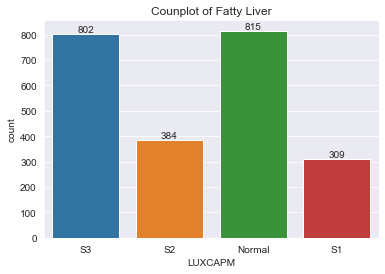

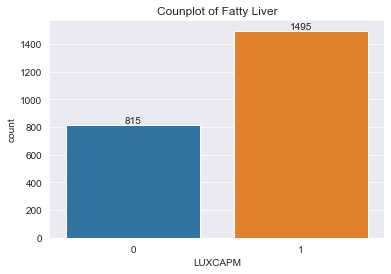

              precision    recall  f1-score   support

           0       0.61      0.36      0.45       257
           1       0.70      0.86      0.77       436

    accuracy                           0.68       693
   macro avg       0.65      0.61      0.61       693
weighted avg       0.66      0.68      0.65       693



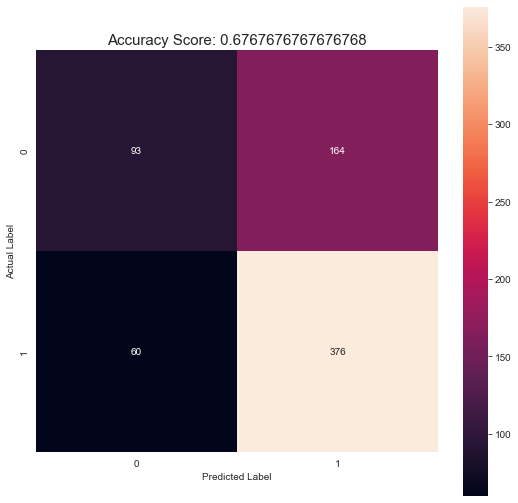

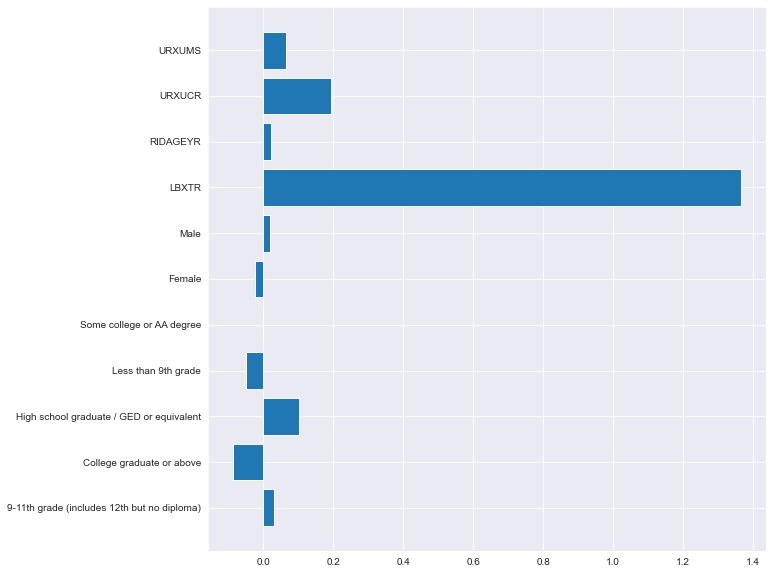

Optimization terminated successfully.
         Current function value: 0.568662
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                LUXCAPM   No. Observations:                 1617
Model:                          Logit   Df Residuals:                     1606
Method:                           MLE   Df Model:                           10
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                  0.1175
Time:                        12:19:02   Log-Likelihood:                -919.53
converged:                       True   LL-Null:                       -1041.9
Covariance Type:            nonrobust   LLR p-value:                 6.809e-47
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
9-11th grade (includes 12th but no diploma

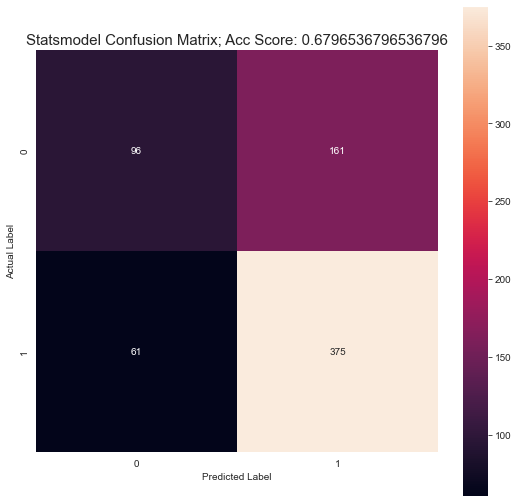

9-11th grade (includes 12th but no diploma)             NaN
College graduate or above                               NaN
High school graduate / GED or equivalent                NaN
Less than 9th grade                                     NaN
Some college or AA degree                               NaN
Female                                                  NaN
Male                                                    NaN
LBXTR                                          6.656216e-26
RIDAGEYR                                       3.410561e-11
URXUCR                                         1.067390e-03
URXUMS                                         3.933963e-01
dtype: float64
                                                   OR  Lower CI  Higher CI
9-11th grade (includes 12th but no diploma)  0.946915       NaN        NaN
College graduate or above                    0.840996       NaN        NaN
High school graduate / GED or equivalent     1.017237       NaN        NaN
Less than 9th grade      

In [16]:
%matplotlib inline

# Import necessary files.
demographics = pd.read_csv('./P_DEMO.csv', encoding='latin1')
liver_csv = pd.read_csv('./P_LUX.csv', encoding='latin1')
trygly = pd.read_csv('./P_TRIGLY.csv', encoding='latin1')
albu_cr = pd.read_csv('./P_ALB_CR.csv', encoding='latin1')

# Select columns of interest - see data_variables_to_use.txt for descritpions.
demo_x = pd.DataFrame(demographics[['SEQN', 'RIAGENDR', 'DMDEDUC2', 'RIDAGEYR']])
trygly_x = pd.DataFrame(trygly[['SEQN', 'LBXTR']])
albu_cr_x = pd.DataFrame(albu_cr[['SEQN', 'URXUMS', 'URXUCR']])

# Select desired outcomes - ultimately use LUXCAPM.
liver_y = pd.DataFrame(liver_csv[['SEQN', 'LUXSMED', 'LUXCAPM']])

# Merge the various csvs on SEQN
data_df = demo_x.merge(liver_y, on='SEQN', how='inner')
data_df = data_df.merge(trygly_x, on='SEQN', how='inner')
data_df = data_df.merge(albu_cr_x, on='SEQN', how='inner')
data_df.dropna(axis=0, inplace=True)

# Standardize continuous variables
scalar = StandardScaler()
data_df['URXUMS'] = scalar.fit_transform(data_df[['URXUMS']])
data_df['URXUCR'] = scalar.fit_transform(data_df[['URXUCR']])
data_df['LBXTR'] = scalar.fit_transform(data_df[['LBXTR']])
# data_df['DR1TCAFF'] = scalar.fit_transform(data_df[['DR1TCAFF']])
# data_df['DR1TCARB'] = scalar.fit_transform(data_df[['DR1TCARB']])

# Create dummy variables for variables.
## age = pd.get_dummies(data_df['DMDHRAGZ'].apply(adjust_age_values))
education = pd.get_dummies(data_df['DMDEDUC2'].apply(adjust_edu_values))
gender = pd.get_dummies(data_df['RIAGENDR'].apply(adjust_gender_values))

liver_damage = pd.get_dummies(data_df['LUXSMED'].apply(set_fatty_liver_categories))
fatty_liver = data_df['LUXCAPM'].apply(adjust_cap_values)

# df to input into logistic regression
final_df = pd.concat([education, gender, fatty_liver, data_df['LBXTR'], data_df['RIDAGEYR'], data_df['URXUCR'], data_df['URXUMS']], axis=1)

# Plot distribution of fatty liver stages.
ax = sns.countplot(x='LUXCAPM', data=final_df)
ax.bar_label(ax.containers[0])
ax.set_title('Counplot of Fatty Liver')
plt.show()

# Create outcome labels.
labels = pd.DataFrame(final_df['LUXCAPM'])
labels.LUXCAPM[labels.LUXCAPM == 'Normal'] = 0
labels.LUXCAPM[labels.LUXCAPM == 'S1'] = 1
labels.LUXCAPM[labels.LUXCAPM == 'S2'] = 1
labels.LUXCAPM[labels.LUXCAPM == 'S3'] = 1

# Plot distribution of label categories
ax = sns.countplot(x='LUXCAPM', data=labels)
ax.bar_label(ax.containers[0])
ax.set_title('Counplot of Fatty Liver')
plt.show()


# Drop non-useful columns and the outcome column
final_df.drop(['LUXCAPM', 'Don\'t Know'], axis=1, inplace=True)
final_df = final_df.apply(pd.to_numeric)
labels = labels.apply(pd.to_numeric)


# Create test and train sets.
x_train, x_test, y_train, y_test = train_test_split(
    final_df, labels, test_size=0.3, random_state=0
)

# Logistic Regression scikit
logmodel = LogisticRegression()
logmodel.fit(x_train, np.ravel(y_train))
predict_log = logmodel.predict(x_test)

# Model evaluation starts here:
print(classification_report(y_test, predict_log))
score = logmodel.score(x_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_test, predict_log)
plt.figure(figsize=(9,9))
sns.heatmap(cm, fmt='g', annot=True, square=True)
plt.ylabel('Actual Label')
plt.xlabel("Predicted Label")
plt.title(f'Accuracy Score: {score}', size=15)
plt.show()

# Variable importance
importance = logmodel.coef_.flatten()
plt.figure(figsize=(10,10))
plt.barh(final_df.columns, importance)
plt.show()

# Logistic Regression statsmodel
logreg = sm.Logit(y_train, x_train).fit()
print(logreg.summary())
logpredict = logreg.predict(x_test)
prediction = list(map(round, logpredict))
cm_statsmodel = confusion_matrix(y_test, prediction)
score_statsmodel = accuracy_score(y_test, prediction)
plt.figure(figsize=(9,9))
sns.heatmap(cm_statsmodel, fmt='g', annot=True, square=True)
plt.ylabel('Actual Label')
plt.xlabel("Predicted Label")
plt.title(f'Statsmodel Confusion Matrix; Acc Score: {score_statsmodel}', size=15)
plt.show()

print(logreg.pvalues)

# Statsmodel odds ratios
odds_ratios = pd.DataFrame({
    "OR": logreg.params,
    "Lower CI": logreg.conf_int()[0],
    "Higher CI": logreg.conf_int()[1]
})

odds_ratios = np.exp(odds_ratios)
print(odds_ratios)